# Performance of Different Word Embeddings on Text Classification

## Compared among word2vec, TF-IDF weighted, GloVe and doc2vec

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from numpy import random
import gensim
import spacy
import nltk
import os
import pickle

import matplotlib.pyplot as plt
import re
import warnings
warnings.simplefilter('ignore')
pd.set_option('max_colwidth',1000)


%matplotlib inline

# Abstract

## The Incentive

It's been a while not able to write new posts, so sad, but now finally I am back again to share some of the knowledge I've just acquired. This time is about NLP. 

As a fresh rookie in NLP, I'd like to play around and test out how different methods of creating doc vector perform on text classification. This post will be highly focused on feature engineering side, that is word vectorization, and less on modeling. Thus, without further due, let's get started.

## Brief Introduction

The word embeddings being investigated here are word2vec, TF-IDF weighted word2vec, pre-train GloVe word2vec and doc2vec. The packages needed are Gensim, Spacy and Scikit-Learn. Spacy is used in doc preprocessing, including stop word removal and custom token selection based on its part of speech. Gensim is heavily applied for training word2vec and doc2vec, and lastly, Scikit-Learn is for classifier building and training.

## Quick Summary

After a series of comparison on different word embedding/averaging methods, it turns out that custom-trained word embedding and its averaging method, either simple mean or TF-IDF weighted has the best performance, while on the contrary, GloVe word embedding or custom-trained Doc2vec perform slightly worse than the former word embedding.

Besides, even if we try to concatenate both word2vec and doc2vec as a whole feature set, it performs equally the same to just using averaging word embedding alone. In other words, no need to use both word2vec and doc2vec at the same time.


| WordEmbedding Method        | F1 Score - Training | F1 Score - Testing | Accuracy - Training | Accuracy - Testing |
| :---:                       | :---:               | :---:              | :---:               | :---:              |
| Mean Word2vec               | 0.82                | 0.81               | 0.82                | 0.81               |
| Tf-Idf Mean Word2vec        | 0.82                | 0.81               | 0.82                | 0.81               |
| GloVe Mean Word2vec         | 0.72                | 0.71               | 0.73                | 0.72               |
| PV-DM Doc2vec               | 0.79                | 0.78               | 0.79                | 0.78               |
| Tf-Idf Word2vec + Doc2vec   | 0.84                | 0.81               | 0.85                | 0.82               |


## Special Credits to the Following Posts and Authors

In creating my **python class object** used for text preprocessing, I referred from these well-written posts.

* The post ["Text Classification with Word2vec"](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/) by nadbor demos how to write your own class to compute average word embedding for doc, either simple averaging or TF-IDF weighted one.

* ["Multi-Class Text Classification Model Comparison and Selection"](https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568) by Susan Li teaches me how to write beautiful averaging function for word embedding.

* This tutorial ["Gensim Doc2vec Tutorial on the IMDB Sentiment Dataset"](https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb) has step by step guidance on how to create doc2vec via Gensim.

* ["Distributed representations of sentences and documents"](https://blog.acolyer.org/2016/06/01/distributed-representations-of-sentences-and-documents/) by Le & Mikolov presents a clear and easy-to-understand explanation on what's going under doc2vec.

# Data Preparation

The dataset I am gonna use here is consumer complaints dataset on financial product/service as referred from [the post](https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4). The dataset is collected and published by [US GOV CFPB](https://catalog.data.gov/dataset/consumer-complaint-database), while we can also download the dataset from [Kaggle](https://www.kaggle.com/cfpb/us-consumer-finance-complaints).

The original dataset contains more than 500 thousands records, and columns include product, sub_product, issue, consumer_complaint_narrative, and company_response_to_consumer etc.. We will just use **product** as text label and **consumer_complaint_narrative** as text itself. After dropping rows of missing values on consumer complaint we are left with around 60 thousands records. In order to lessen the computing pressure, I will just experiment on the first 25 thousands records only.

## Read in Dataset

In [3]:
# Read in file.
dir_path = '../Private-Dataset'

df = pd.read_csv(os.path.join(dir_path, 'consumer_complaints_simple.csv'))
df = df[pd.notnull(df['consumer_complaint_narrative'])]

## Get Familiar with Dataset

In [4]:
# Get familiar with dataset.
df.shape

(66806, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66806 entries, 0 to 66805
Data columns (total 18 columns):
date_received                   66806 non-null object
product                         66806 non-null object
sub_product                     46351 non-null object
issue                           66806 non-null object
sub_issue                       32932 non-null object
consumer_complaint_narrative    66806 non-null object
company_public_response         32776 non-null object
company                         66806 non-null object
state                           66620 non-null object
zipcode                         66617 non-null object
tags                            11417 non-null object
consumer_consent_provided       66806 non-null object
submitted_via                   66806 non-null object
date_sent_to_company            66806 non-null object
company_response_to_consumer    66806 non-null object
timely_response                 66806 non-null object
consumer_disputed?         

In [ ]:
df.to_csv(os.path.join(dir_path, 'consumer_complaints_simple.csv'), index=False)

## Filter on Text and Label

In [6]:
# Filter on text and label.
df = df[['product','consumer_complaint_narrative']]

In [7]:
# Experiment on smaller subset.
df = df[:25000]

<mark>**Chart of Label Frequency**</mark>

Now, let's see how frequency distributed among each label.

In [ ]:
# Distribution of target variable.
display(df['product'].value_counts())

# df[['product', 'sub_product']].apply(lambda x: str(x[0]) + '///' + str(x[1]),
#                                      axis=1).value_counts()

Frequency(Top 30)...


,count,freq
Debt collection,7093,0.28372
Mortgage,5703,0.22812
Credit reporting,4584,0.18336
Credit card,2750,0.11000
Bank account or service,1923,0.07692
Consumer Loan,1292,0.05168
Student loan,917,0.03668
Payday loan,273,0.01092
Money transfers,270,0.01080
Prepaid card,154,0.00616


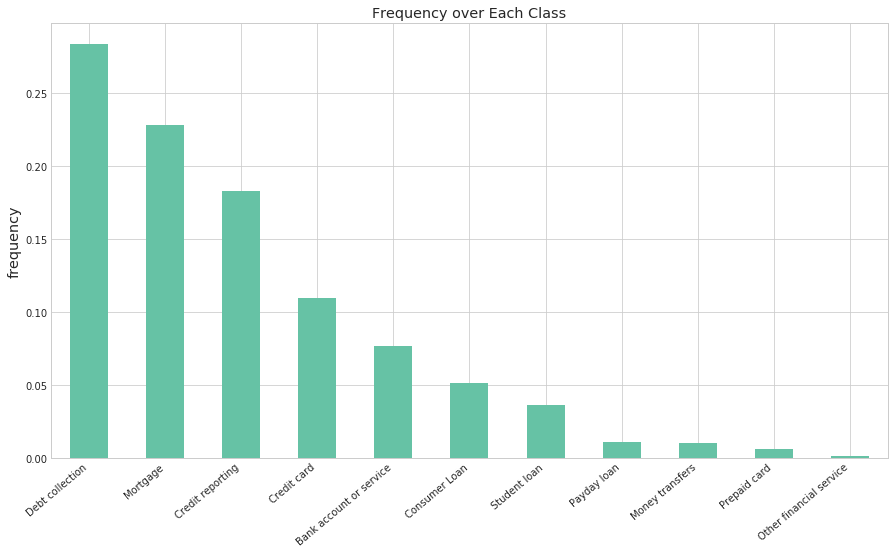

In [8]:
from UtilTextClassification import plot_freq

plot_freq(df, col=['product'], top_classes=30)

<mark>**Sample of Dataset**</mark>

Demo of (product, complaints) example to get a feeling of what complaints will be like to corresponding product.

In [9]:
print('Demo of product and its complaint example...')
df.head()

Demo of product and its complaint example...


,product,consumer_complaint_narrative
0,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! \nThey continue to insist I owe them and collection agencies are after me. \nHow can I stop this harassment for a bill I already paid four years ago? \n
1,Consumer Loan,"Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining debt. I then sent the goodwill letter still offering to pay the remainder of the debt, but in exchange for the removal of the negative entry on my credit report. At one point, in XXXX 2015, per my credit monitoring agency, it showed a delinquent balance of {$0.00}, but when I checked my credit report again on XXXX X..."
2,Mortgage,"In XX/XX/XXXX my wages that I earned at my job decreased by almost half, by XX/XX/XXXX I knew I was in trouble with my home loan. I began contacting WFB whom my home loan is with, for assitance and options. \nIn early XX/XX/XXXX I began the Loan Modification process with Wells Fargo Bank. I was told that they would not assist me with anything financial on my home loan until I fell 90 days behind, though at the time I started to inquire for assistance from WFB I was only a few weeks behind. So, I began working with a program called XXXX. They approved me for a variety of assistence and reached out to Wells Fargo Bank to determine what they could assist with. Wells Fargo then turned down the assistance from XXXX and finally offered to do a Loan Modification for me. The outcome was totally unknow about what I would be offered in the end by WFB for assistance. Wells Fargo lost my paperwork twice during this process, so it took 2 months from the time I started to the time my paperwork b..."
3,Mortgage,"I have an open and current mortgage with Chase Bank # XXXX. Chase is reporting the loan payments to XXXX but XXXX is surpressing the information and reporting the loan as Discharged in BK. This mortgage was reaffirmed in a Chapter XXXX BK discharged dated XXXX/XXXX/2013. Chase keeps referring to BK Law for Chapter XXXX and we keep providing documentation for Chapter XXXX, and the account should be open and current with all the payments \n"
4,Mortgage,"XXXX was submitted XX/XX/XXXX. At the time I submitted this complaint, I had dealt with Rushmore Mortgage directly endeavoring to get them to stop the continuous daily calls I was receiving trying to collect on a mortgage for which I was not responsible due to bankruptcy. They denied having knowledge of the bankruptcy, even though I had spoken with them about it repeatedly and had written them repeatedly referencing the bankruptcy requesting them to cease the pursuit, they continued to do so. When they were unable to trick me into paying, force me into paying in retaliation they placed reported to my credit bureaus a past due mortgage amount that had been discharged in Federal Court. On XX/XX/XXXX Rushmore responded the referenced complaint indicating that they would remove the reporting from my bureau, yet it is still there now in XX/XX/XXXX. I would like them to remove it immediately and send me a letter indicating that it should not have been there in the first place and they ar..."


# Document Preprocessing

Now comes the first step -Doc Preprocessing. Before we create our own word embedding based on the input texts, we need to preprocess the text so that it complies with the input format as Gensim requires. It involves multiple steps starting from word tokenization, bi-gram detection, lemmatization etc..

Here, I wrote a python class called **DocProcess**. This class implements all the nitty-gritty jobs mentioned above for us under the hood, such as:

1. First, the class takes in a series of texts, then tokenizes the text and removes all punctuations.

2. It has the option build_bi, meaning whether to build up bi-gram, function adopted from Gensim. The default is False, if option build_bi is set to True, then the class will train a bi-gram detector and create bi-gram words for the text.

3. Now, all the processed tokens are concatenated back to form a sentence again.

4. The texts are tokenized once again, but this time, both **stop words** and **parts of speech** that are not allowed in the text will be removed and all tokens are **lemmatized**. These tokens are stored as `self.doc_words` - list of the tokens for each text(doc).

5. Finally, these `self.doc_words` are wrapped up into **TaggedDocument**, a object type in Gensim for later use in doc2vec training. It's stored in `self.tagdocs`.

In [5]:
import spacy


nlp = spacy.load('en_core_web_md')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [ ]:
from UtilWordEmbedding import DocPreprocess



all_docs = DocPreprocess(nlp, stop_words, df['consumer_complaint_narrative'], df['product'])

In [ ]:
import pickle


# Save all_docs as pickle.
with open(os.path.join(dir_path, 'all_docs.pickle'), 'wb') as f:
    pickle.dump(all_docs, f, pickle.HIGHEST_PROTOCOL)

In [4]:
import pickle


# Read pickle.
with open(os.path.join(dir_path, 'all_docs.pickle'), 'rb') as f:
    all_docs = pickle.load(f)

## Deomo - Structure of Preprocessed Docs

In [6]:
# Demo: structure of preprocessed docs.
type(all_docs)

UtilWordEmbedding.DocPreprocess

In [7]:
len(all_docs.tagdocs)

25000

In [8]:
print('Demo of tagged document...')
all_docs.tagdocs[4]

Demo of tagged document...


TaggedDocument(words=['xxxx', 'submit', 'xx', 'time', 'submit', 'complaint', 'deal', 'rushmore', 'mortgage', 'directly', 'endeavor', 'stop', 'continuous', 'daily', 'call', 'receive', 'try', 'collect', 'mortgage', 'responsible', 'bankruptcy', 'deny', 'have', 'knowledge', 'bankruptcy', 'speak', 'repeatedly', 'write', 'repeatedly', 'reference', 'bankruptcy', 'request', 'cease', 'pursuit', 'continue', 'unable', 'trick', 'pay', 'force', 'pay', 'retaliation', 'place', 'report', 'credit', 'bureau', 'mortgage', 'discharge', 'federal', 'court', 'xx', 'xx', 'xxxx', 'rushmore', 'respond', 'reference', 'complaint', 'indicate', 'remove', 'reporting', 'bureau', 'xx', 'xx', 'like', 'remove', 'immediately', 'send', 'letter', 'indicate', 'place', 'go', 'remove', 'bureaus', 'rushmore', 'speak', 'represent', 'new', 'note', 'holder', 'cfpb', 'involve', 'identify', 'servicing', 'agency', 'xxxx', 'credit', 'bullying', 'racial', 'discrimination', 'practice', 'damaging', 'expose', 'tactic', 'need', 'stop', 'd

In [10]:
print('Demo of doc words...')
all_docs.doc_words[4][:10]

Demo of doc words...


['xxxx',
 'submit',
 'xx',
 'time',
 'submit',
 'complaint',
 'deal',
 'rushmore',
 'mortgage',
 'directly']

In [11]:
print('Label of tagged document...')
all_docs.labels.iloc[4]

Label of tagged document...


'Mortgage'

# Build up Word Model - Word2vec

Since the text are properly processed, we're ready to train our word2vec via Gensim. Here I chose the dimension size 100 for each word embedding and window size of 5. The training iterates for 100 times.

In [13]:
import multiprocessing
import sys
from gensim.models.word2vec import Word2Vec

workers = multiprocessing.cpu_count()
print('number of cpu: {}'.format(workers))
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise."

number of cpu: 8


In [34]:
word_model = Word2Vec(all_docs.doc_words,
                      min_count=2,
                      size=100,
                      window=5,
                      workers=workers,
                      iter=100)

# Averaging Word Embedding for Each Doc

OK! Now we have the word embedding at hand, we'll be using the word embedding to compute for representative vector for whole text. It then serves as feature input for text classification model. There are various ways to come up with doc vector. First, let's start with the simple one.

## Simple Averaging on Word Embedding

This is a rather straightforward method. It directly averages all word embedding occurred in the text. Here I adapted the code from these two posts [2](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/), [3](https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568) and created the python class **MeanWordEmbeddingVectorizer**.

In [35]:
from UtilWordEmbedding import MeanEmbeddingVectorizer


mean_vec_tr = MeanEmbeddingVectorizer(word_model)
doc_vec = mean_vec_tr.transform(all_docs.doc_words)

# print('Demo of word averaging doc vector...')
# display(doc_vec[4])

In [36]:
# Save word averaging doc2vec.
print('Shape of word-mean doc2vec...')
display(doc_vec.shape)
print('Save word-mean doc2vec as csv file...')
np.savetxt(os.path.join(dir_path,'doc_vec.csv'), doc_vec, delimiter=',')

Shape of word-mean doc2vec...


(25000, 100)

Save word-mean doc2vec as csv file...


## TF-IDF Weighted Averaging on Word Embedding

Not just satisfied with simple averaging? We can further adopt TF-IDF as weights for each word embedding. This will amplify the role of significant word in computing doc vector. Here, the whole process is implemented under class **TfidfEmbeddingVectorizer**. Again, the code is adapted from the same post source.

One thing worth noted is that, the Term Frequency has already been considered when we conduct averaging over the text, but not Inverse Document Frequency, thus the weight literally being the IDF, and the unseen word is assigned the max IDF in default setting.

And the other thing to note is that we need to fit the class with tokens first, for it must loop through all the words before hand in order to compute IDF.

In [20]:
from UtilWordEmbedding import TfidfEmbeddingVectorizer



tfidf_vec_tr = TfidfEmbeddingVectorizer(word_model)

In [21]:
tfidf_vec_tr.fit(all_docs.doc_words)  # fit tfidf model first
tfidf_doc_vec = tfidf_vec_tr.transform(all_docs.doc_words)


# print('Demo of tf-idf word averaging doc vector...')
# display(tfidf_doc_vec[4])

In [22]:
# Save tfidf word averaging doc2vec.
print('Shape of tfidf-word-mean doc2vec...')
display(tfidf_doc_vec.shape)
print('Save tfidf-word-mean doc2vec as csv file...')
np.savetxt(os.path.join(dir_path, 'tfidf_doc_vec.csv'), tfidf_doc_vec, delimiter=',')

Shape of tfidf-word-mean doc2vec...


(25000, 100)

Save tfidf-word-mean doc2vec as csv file...


## Leverage Pre-train GloVe Word Embedding

### Load in GloVe Vector

Let's include another option - leveraging the existing pre-trained word embedding and see how it performs in text classification. Here I follow up the instructions from [Stanford NLP course(CS224N) notebook](http://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html), importing GloVe word embedding into Gensim to compute for averaging word embedding on text.

As a side note, I've also tried to apply Tf-IDF weighted method on GloVe vector, but found out that the result is basically the same as the ones from TF-IDF weighted averaging doc vector. Thus, I omit the demonstration and just include simple averaging on GloVe word vector here.

<mark>**APPENDIX: The explanation for logic behind loading pre-train word vector.**</mark>

The result of `datapath()` shows that Gensim will try to load in dataset from */Users/XXX/miniconda3/lib/python3.7/site-packages/gensim/test/test_data/*, and calls it `glove_vec_fi`.

It then uses `get_tmpfile()` to create a temporary file path to store the word2vec `tmp_word2vec_fi`, which is converted from `glove_vec_fi`.

At the final step, **KeyedVectors** then loads in the `tmp_word2vec_fi` as word model.

In [27]:
from gensim.test.utils import get_tmpfile, datapath
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec



# Load in GloVe vector.
glove_vec_fi = datapath('glove.twitter.27B/glove.twitter.27B.100d.txt')
tmp_word2vec_fi = get_tmpfile('tmp_glove2word2vec.txt')

glove2word2vec(glove_vec_fi, tmp_word2vec_fi)

glove_word_model = KeyedVectors.load_word2vec_format(tmp_word2vec_fi)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/ubuntu/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/ubuntu/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migr

### Simple Averaging on GloVe Word Embedding

In [37]:
# Apply word averaging on GloVe word vector.
glove_mean_vec_tr = MeanEmbeddingVectorizer(glove_word_model)

In [38]:
glove_doc_vec = glove_mean_vec_tr.transform(all_docs.doc_words)


# print('Demo of GloVe word averaging doc vector...')
# display(glove_doc_vec[4])

In [39]:
# Examine if glove_doc_vec is equal to self-trained doc_vec.
print('Examine if glove_doc_vec is equal to self-trained doc_vec...')
glove_doc_vec[4] == doc_vec[4]

Examine if glove_doc_vec is equal to self-trained doc_vec...


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [40]:
# Save glove word averaging doc2vec.
print('Shape of glove-word-mean doc2vec...')
display(glove_doc_vec.shape)
print('Save glove-word-mean doc2vec as csv file...')
np.savetxt(os.path.join(dir_path, 'glove_doc_vec.csv'), glove_doc_vec, delimiter=',')

Shape of glove-word-mean doc2vec...


(25000, 100)

Save glove-word-mean doc2vec as csv file...


## Apply Doc2vec Training Directly

### PV-DM Model

Last but not least, we still have one more option - to directly train doc2vec, and no need to average all word embeddings. Here I chose **PV-DM model** to train my doc2vec.

The script is mostly referred from [Gensim tutorial](https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb). And again, to save all the labor, I create a class **DocModel** for it. The class just needs to take in the **TaggedDocument** and then we call `self.custom_train()` method, the doc model will train itself.

<mark>**APPENDIX: Training with Fixed Learning Rate.**</mark>

It's said to achieve better result, but the statement is from a rather old-version gensim tutorial. I found no better training result out of using fixed learning rate. Instead, using the default one, which is also recommended by the new gensim document achieving better performance.

Excerpted from [Doc2vec tutorial](https://rare-technologies.com/doc2vec-tutorial/)

I have obtained better results by iterating over the data several times and either

1. randomizing the order of input sentences, or
2. manually controlling the learning rate over the course of several iterations.

In [14]:
from UtilWordEmbedding import DocModel

# Configure keyed arguments for Doc2Vec model.
dm_args = {
    'dm': 1,
    'dm_mean': 1,
    'vector_size': 100,
    'window': 5,
    'negative': 5,
    'hs': 0,
    'min_count': 2,
    'sample': 0,
    'workers': workers,
    'alpha': 0.025,
    'min_alpha': 0.025,
    'epochs': 100,
    'comment': 'alpha=0.025'
}

In [15]:
# Instantiate a pv-dm model.
dm = DocModel(docs=all_docs.tagdocs, **dm_args)

In [16]:
dm.custom_train()

In [ ]:
# Demo: doc vector.
# dm.model.docvecs[0]

In [17]:
# Save doc2vec as feature dataframe.
dm_doc_vec_ls = []
for i in range(len(dm.model.docvecs)):
    dm_doc_vec_ls.append(dm.model.docvecs[i])


dm_doc_vec = pd.DataFrame(dm_doc_vec_ls)
print('Shape of dm doc2vec...')
display(dm_doc_vec.shape)

print('Save dm doc2vec as csv file...')
dm_doc_vec.to_csv(os.path.join(dir_path, 'dm_doc_vec.csv'), index=False, header=False)

Shape of dm doc2vec...


(25000, 100)

Save dm doc2vec as csv file...


## Save Target Label

In [ ]:
print('Shape of target labels...')
display(all_docs.labels.shape)
target_labels = all_docs.labels

print('Save target labels...')
target_labels.to_csv(os.path.join(dir_path, 'target_labels.csv'), index=False, header=True)

# Prepare the Classification Model

Now, we've prepared all the necessary ingredients - different types of features. Let's experiment to observe their effect on classification performance. Here, I'll use **basic logistic model** as the base model and feed in different kind of features created earlier. Hence, to compare their effectiveness.

In addition to compare effects of each word embedding averaging method, I also try to **concatenate word2vec and doc2vec** together, and see if it can boost up the performance even more.

I used TF-IDF weighted word embedding and PV-DM doc2vec together. The result shows that it increases the accuracy on training dataset (perhaps a sign of over-fitting?), but not so significant improvement on testing dataset compared using TF-IDF word2vec alone.

In [4]:
import os

# Read in saved files.
dir_path = '../Private-Dataset'

doc_vec = pd.read_csv(os.path.join(dir_path, 'doc_vec.csv'), header=None)
tfidf_doc_vec = pd.read_csv(os.path.join(dir_path, 'tfidf_doc_vec.csv'), header=None)
glove_doc_vec = pd.read_csv(os.path.join(dir_path, 'glove_doc_vec.csv'), header=None)
dm_doc_vec = pd.read_csv(os.path.join(dir_path, 'dm_doc_vec.csv'), header=None)
target_labels = pd.read_csv(os.path.join(dir_path, 'target_labels.csv'), header=0)

## Set up Model

In [5]:
from sklearn.linear_model import LogisticRegression


# Classification via Logistic Model
logistic = LogisticRegression(random_state=1, multi_class='multinomial', solver='saga')

In [ ]:
from sklearn.linear_model import SGDClassifier

# (Optional) Classification via stochastic gradient descent classifier.
sgd = SGDClassifier(loss='hinge',
                    penality='l2',
                    verbose=1,
                    random_state=1,
                    learning_rate='invscaling',
                    eta0=1)

## (Demo) Hyper-Parameters

In [ ]:
model = logistic  # or choose sgd.
df = tfidf_doc_vec
concate = False
concat_df = dm_doc_vec

## Define Train Function

In [6]:
from UtilTextClassification import split_size
from sklearn.model_selection import train_test_split




def main(model, df, concate, concat_df):
    if concate:
        df = pd.concat([df, concat_df], axis=1, ignore_index=True)
    else:
        df = df

    # Specify train/valid/test size.
    train_size, valid_size, test_size = split_size(df, train=0.7, valid=0.)  # no need to use valid dataset here
    # Prepare test dataset.
    train_X, test_X, train_y, test_y = train_test_split(df,
                                                    target_labels,
                                                    test_size=test_size,
                                                    random_state=1,
                                                    stratify=target_labels)

    # Prepare valid dataset.
    if valid_size != 0:
        train_X, valid_X, train_y, valid_y = train_test_split(train_X,
                                                      train_y,
                                                      test_size=valid_size,
                                                      random_state=1,
                                                      stratify=train_y)
    
    print('Shape of train_X: {}'.format(train_X.shape))
    print('Shape of valid_X: {}'.format(valid_X.shape if 'valid_X' in vars() else (0,0)))
    print('Shape of text_X: {}'.format(test_X.shape))
    
    model.fit(train_X, train_y)
    
    if valid_size != 0:
        return model, train_X, valid_X, test_X, train_y, valid_y, test_y
    else:
        return model, train_X, None, test_X, train_y, None, test_y

# Test Model

## Performance on Simple Averaging Word Vector

### Hyper-Parameters

In [7]:
model = logistic  # or choose sgd.
df = doc_vec
concate = False
concat_df = dm_doc_vec

### Train

In [8]:
# __main__
clf, train_X, valid_X, test_X, train_y, valid_y, test_y = main(model, 
                                                               df, 
                                                               concate=concate, 
                                                               concat_df=concat_df)

Shape of train_X: (17500, 100)
Shape of valid_X: (0, 0)
Shape of text_X: (7500, 100)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Test on Training Dataset

In [9]:
from UtilTextClassification import sk_evaluate


# Score on valid dataset.
print('Performance of Mean Word Vector on training dataset...')
_, _ = sk_evaluate(clf, train_X, train_y, label_names=None)

Performance of Mean Word Vector on training dataset...
Score on dataset...

Confusion Matrix:
 [[1048   11  141   32   33   22   47    0    0    9    3]
 [  27  475   55   79  162    3   81    0   16    0    6]
 [ 114   16 1483  120  157    5   25    0    1    3    1]
 [  17   40   83 2609  369    2   72    0    1    1   15]
 [  34   48   84  295 4354    3   87    0   12    1   47]
 [  37    1    8    0    8  128    3    0    1    3    0]
 [  29   24   27   65   68    2 3769    0    2    0    6]
 [  10    0    3    1    8    4    3    0    0    0    0]
 [   8   19    5    7   67    3   12    0   67    0    3]
 [  23    0   40    1    1    2    0    0    0   41    0]
 [   4    8    4   16   71    1   21    0    0    0  517]]

Classification Report:
                          precision    recall  f1-score   support

Bank account or service       0.78      0.78      0.78      1346
          Consumer Loan       0.74      0.53      0.61       904
            Credit card       0.77      0.77 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Test on Testing Dataset

In [10]:
# Score on test dataset.
print('Performance of Mean Word Vector on testing dataset...')
_, _ = sk_evaluate(clf, test_X, test_y, label_names=None)

Performance of Mean Word Vector on testing dataset...
Score on dataset...

Confusion Matrix:
 [[ 435    5   54   13   17   14   33    1    3    2    0]
 [  11  200   16   28   80    1   39    1    4    0    8]
 [  41    6  629   64   64    2   13    0    0    4    2]
 [   9   26   44 1101  144    1   40    0    2    0    8]
 [  13   27   50  135 1833    0   42    0   11    1   16]
 [  23    0    7    2    1   43    3    1    1    0    0]
 [  12   12    5   29   29    0 1621    0    0    1    2]
 [   4    0    1    2    4    0    0    1    0    0    0]
 [   2   15    3    1   26    0    7    0   25    0    3]
 [   8    0   16    0    2    3    1    0    2   14    0]
 [   2    3    2   14   29    0    9    0    1    0  215]]

Classification Report:
                          precision    recall  f1-score   support

Bank account or service       0.78      0.75      0.77       577
          Consumer Loan       0.68      0.52      0.59       388
            Credit card       0.76      0.76  

## Performance on Tf-Idf Weighted Averaging Word Vector

### Hyper-Parameters

In [11]:
model = logistic  # or choose sgd.
df = tfidf_doc_vec
concate = False
concat_df = dm_doc_vec

### Train

In [12]:
# __main__
clf, train_X, valid_X, test_X, train_y, valid_y, test_y = main(model, 
                                                               df, 
                                                               concate=concate, 
                                                               concat_df=concat_df)

Shape of train_X: (17500, 100)
Shape of valid_X: (0, 0)
Shape of text_X: (7500, 100)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Test on Training Dataset

In [13]:
from UtilTextClassification import sk_evaluate


# Score on valid dataset.
print('Performance of Tf-Idf Mean Word Vector on training dataset...')
_, _ = sk_evaluate(clf, train_X, train_y, label_names=None)

Performance of Tf-Idf Mean Word Vector on training dataset...
Score on dataset...

Confusion Matrix:
 [[1035   14  155   26   37   16   51    0    1    7    4]
 [  24  474   56   82  160    2   87    0   14    0    5]
 [ 108   18 1471  122  161    5   32    0    2    3    3]
 [  23   39   77 2608  376    3   66    0    1    0   16]
 [  38   53  101  301 4322    3   88    0   12    1   46]
 [  38    1    9    1    8  126    3    0    0    3    0]
 [  33   24   27   70   65    3 3763    0    1    0    6]
 [   8    0    4    1    5    5    2    4    0    0    0]
 [   7   21    8    7   66    3   10    0   68    0    1]
 [  21    0   36    0    5    2    0    0    0   44    0]
 [   5    7    4   12   72    1   22    0    1    0  518]]

Classification Report:
                          precision    recall  f1-score   support

Bank account or service       0.77      0.77      0.77      1346
          Consumer Loan       0.73      0.52      0.61       904
            Credit card       0.76    

### Test on Testing Dataset

In [14]:
# Score on test dataset.
print('Performance of Tf-Idf Mean Word Vector on testing dataset...')
_, _ = sk_evaluate(clf, test_X, test_y, label_names=None)

Performance of Tf-Idf Mean Word Vector on testing dataset...
Score on dataset...

Confusion Matrix:
 [[ 440    3   52   14   16   13   33    0    3    3    0]
 [  12  192   24   26   79    1   42    1    5    0    6]
 [  49    4  623   66   65    1   13    0    0    3    1]
 [  12   23   38 1113  144    1   34    0    1    0    9]
 [  16   26   42  139 1833    1   40    0   10    1   20]
 [  21    0    7    1    4   44    2    1    1    0    0]
 [  16    7    9   29   34    0 1612    0    1    1    2]
 [   4    0    1    2    4    0    0    1    0    0    0]
 [   3   12    3    1   28    0    5    0   27    0    3]
 [   5    0   19    0    2    3    1    0    2   14    0]
 [   1    4    2   11   34    0   10    0    0    0  213]]

Classification Report:
                          precision    recall  f1-score   support

Bank account or service       0.76      0.76      0.76       577
          Consumer Loan       0.71      0.49      0.58       388
            Credit card       0.76     

## Performance on Simple Averaging of GloVe Word Vector

### Hyper-Parameters

In [15]:
model = logistic  # or choose sgd.
df = glove_doc_vec
concate = False
concat_df = dm_doc_vec

### Train

In [16]:
# __main__
clf, train_X, valid_X, test_X, train_y, valid_y, test_y = main(model, 
                                                               df, 
                                                               concate=concate, 
                                                               concat_df=concat_df)

Shape of train_X: (17500, 100)
Shape of valid_X: (0, 0)
Shape of text_X: (7500, 100)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Test on Training Dataset

In [17]:
from UtilTextClassification import sk_evaluate


# Score on valid dataset.
print('Performance of GloVe Mean Word Vector on training dataset...')
_, _ = sk_evaluate(clf, train_X, train_y, label_names=None)

Performance of GloVe Mean Word Vector on training dataset...
Score on dataset...

Confusion Matrix:
 [[ 882    8  197   45  120    6   82    0    1    3    2]
 [  41  299   55   85  187    0  214    0   10    0   13]
 [ 121   17 1231  157  319    1   72    0    1    0    6]
 [  39   34  107 2385  477    1  148    0    1    0   17]
 [  67   36  111  407 4062    0  240    0    5    0   37]
 [  67    3   24    4   39   40   12    0    0    0    0]
 [  45   17   37  101  194    1 3573    0    0    0   24]
 [   5    0    4    2   10    3    5    0    0    0    0]
 [  14    5   13   10   56    1   48    0   34    0   10]
 [  18    0   56    3   15    1    0    0    2   13    0]
 [   9    6   13   24  104    0  121    0    0    0  365]]

Classification Report:
                          precision    recall  f1-score   support

Bank account or service       0.67      0.66      0.66      1346
          Consumer Loan       0.70      0.33      0.45       904
            Credit card       0.67     

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Test on Testing Dataset

In [18]:
# Score on test dataset.
print('Performance of GloVe Mean Word Vector on testing dataset...')
_, _ = sk_evaluate(clf, test_X, test_y, label_names=None)

Performance of GloVe Mean Word Vector on testing dataset...
Score on dataset...

Confusion Matrix:
 [[ 384    5   68   17   54    3   43    0    2    1    0]
 [   9  139   23   28   77    0  100    0    1    0   11]
 [  51   13  515   77  141    0   24    0    1    2    1]
 [  19   22   48 1007  209    3   62    0    0    0    5]
 [  36   22   57  171 1706    1  113    0    7    1   14]
 [  28    1   14    3   17   14    4    0    0    0    0]
 [  19   10   12   36   88    1 1535    0    1    0    9]
 [   3    0    0    2    6    1    0    0    0    0    0]
 [   5    5    2    1   22    0   29    0   12    0    6]
 [   6    0   28    0    5    2    0    0    2    3    0]
 [   4    6    5   10   46    0   52    0    2    0  150]]

Classification Report:
                          precision    recall  f1-score   support

Bank account or service       0.68      0.67      0.67       577
          Consumer Loan       0.62      0.36      0.45       388
            Credit card       0.67      

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Performance on PV-DM Doc2vec

### Hyper-Parameters

In [19]:
model = logistic  # or choose sgd.
df = dm_doc_vec
concate = False
concat_df = dm_doc_vec

### Train

In [20]:
# __main__
clf, train_X, valid_X, test_X, train_y, valid_y, test_y = main(model, 
                                                               df, 
                                                               concate=concate, 
                                                               concat_df=concat_df)

Shape of train_X: (17500, 100)
Shape of valid_X: (0, 0)
Shape of text_X: (7500, 100)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Test on Training Dataset

In [21]:
from UtilTextClassification import sk_evaluate


# Score on valid dataset.
print('Performance of Doc2vec on training dataset...')
_, _ = sk_evaluate(clf, train_X, train_y, label_names=None)

Performance of Doc2vec on training dataset...
Score on dataset...

Confusion Matrix:
 [[ 996   10  133   52   69   22   55    0    0    6    3]
 [  29  477   40   87  168    3   68    0   18    0   14]
 [  89   28 1414  154  192    6   22    0    3    9    8]
 [  25   48   89 2430  514    0   84    0    2    0   17]
 [  41   53  101  378 4219    3   98    0   21    1   50]
 [  40    1   12    2   15  109    5    0    2    3    0]
 [  33   36   28   81   98    3 3695    1    4    0   13]
 [  10    0    2    2    9    1    0    4    0    0    1]
 [  16   29    9    8   67    1   12    0   38    0   11]
 [  11    0   29    1    2    5    0    1    0   59    0]
 [   8   12    3   17   69    1   22    0    0    0  510]]

Classification Report:
                          precision    recall  f1-score   support

Bank account or service       0.77      0.74      0.75      1346
          Consumer Loan       0.69      0.53      0.60       904
            Credit card       0.76      0.73      0.75

### Test on Testing Dataset

In [22]:
# Score on test dataset.
print('Performance of Doc2vec on testing dataset...')
_, _ = sk_evaluate(clf, test_X, test_y, label_names=None)

Performance of Doc2vec on testing dataset...
Score on dataset...

Confusion Matrix:
 [[ 409    8   56   20   32   12   32    0    1    4    3]
 [   9  194   20   35   76    0   31    0    9    1   13]
 [  48    8  594   75   83    1   10    0    0    5    1]
 [  15   24   60 1046  186    0   33    0    1    0   10]
 [  17   39   46  157 1790    0   44    3    8    2   22]
 [  20    0   13    5    3   34    2    0    0    3    1]
 [  13   16    3   45   50    2 1569    0    5    0    8]
 [   4    1    0    3    3    0    0    0    0    0    1]
 [   0   11    1    5   34    0    4    0   21    0    6]
 [   6    0    9    1    1    3    1    0    1   24    0]
 [   1    4    0   11   29    0    9    0    1    0  220]]

Classification Report:
                          precision    recall  f1-score   support

Bank account or service       0.75      0.71      0.73       577
          Consumer Loan       0.64      0.50      0.56       388
            Credit card       0.74      0.72      0.73 

## Performance on Tf-Idf and Doc2vec Concatenated Feature

### Hyper-Parameters

In [23]:
model = logistic  # or choose sgd.
df = tfidf_doc_vec
concate = True  # set to True.
concat_df = dm_doc_vec

### Train

In [24]:
# __main__
clf, train_X, valid_X, test_X, train_y, valid_y, test_y = main(model, 
                                                               df, 
                                                               concate=concate, 
                                                               concat_df=concat_df)

Shape of train_X: (17500, 200)
Shape of valid_X: (0, 0)
Shape of text_X: (7500, 200)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Test on Training Dataset

In [25]:
from UtilTextClassification import sk_evaluate


# Score on valid dataset.
print('Performance of Tf-Idf Mean Word Vector and Doc2vec Combined on training dataset...')
_, _ = sk_evaluate(clf, train_X, train_y, label_names=None)

Performance of Tf-Idf Mean Word Vector and Doc2vec Combined on training dataset...
Score on dataset...

Confusion Matrix:
 [[1072   14  132   31   29   15   45    0    0    6    2]
 [  25  546   47   71  131    1   54    0   20    0    9]
 [  88   14 1533  104  150    3   25    0    0    4    4]
 [  14   39   66 2690  339    0   46    0    1    0   14]
 [  30   57   93  269 4373    5   80    1   20    0   37]
 [  29    0    7    0    3  145    2    0    1    2    0]
 [  29   25   21   59   56    1 3792    0    3    0    6]
 [   6    0    3    1    6    2    0    9    1    0    1]
 [  10   21    7    5   50    0    6    0   89    0    3]
 [  11    0   23    0    0    0    0    0    0   74    0]
 [   6    8    1   12   50    1   11    0    2    0  551]]

Classification Report:
                          precision    recall  f1-score   support

Bank account or service       0.81      0.80      0.80      1346
          Consumer Loan       0.75      0.60      0.67       904
            Credi

### Test on Testing Dataset

In [26]:
# Score on test dataset.
print('Performance of Tf-Idf Mean Word Vector and Doc2vec Combined on testing dataset...')
_, _ = sk_evaluate(clf, test_X, test_y, label_names=None)

Performance of Tf-Idf Mean Word Vector and Doc2vec Combined on testing dataset...
Score on dataset...

Confusion Matrix:
 [[ 440    4   50   13   13   14   32    0    4    6    1]
 [   9  202   22   25   70    0   32    0   18    1    9]
 [  44    8  625   60   67    4   10    0    0    6    1]
 [  11   21   36 1137  130    1   28    0    2    1    8]
 [  16   36   50  130 1815    0   39    1   18    0   23]
 [  16    0   12    2    3   43    1    1    2    1    0]
 [  11   10    6   26   31    1 1617    0    3    1    5]
 [   4    1    0    2    4    0    0    1    0    0    0]
 [   3   10    2    1   34    0    4    0   24    0    4]
 [   8    0    8    0    1    3    1    0    2   23    0]
 [   1    7    2   13   22    1    6    0    0    0  223]]

Classification Report:
                          precision    recall  f1-score   support

Bank account or service       0.78      0.76      0.77       577
          Consumer Loan       0.68      0.52      0.59       388
            Credit

# (Optional) Grid-Search for Best Hyper-Paremeters on Logistic

<mark>**NOTE:**</mark>

The `log_loss()` from sklearn expects to have predicted probs for each class. Thus, instead of simply using `clf.predict(X)`, we need to use `clf.predict_proba(X)` when computing for y_pred. In other words, if we want to use `GridSearchCV`, it's probabily best to directly specify scoring as **'neg_log_loss'**, instead of creating our own scoring func.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, log_loss

logistic = LogisticRegression(random_state=1,
                              multi_class='multinomial',
                              solver='saga')

params_log = {"max_iter": [100, 200, 500], "C": [1, 2, 5]}


# Ref: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# whether the python function returns a score 
# (greater_is_better=True, the default) or a loss (greater_is_better=False). 
# If a loss, the output of the python function is negated by the scorer object, 
# conforming to the cross validation convention that scorers return higher values for better models.
grid_log = GridSearchCV(logistic, param_grid=params_log, scoring='neg_log_loss', cv=5)

grid_log.fit(train_X, train_y)

print(
    "the best neg_log_loss of all model parameters' combination on model: {:.4f}"
    .format(grid_log.best_score_))

In [ ]:
print("the parameter setting of optimized model: {}".format(
    grid_log.best_estimator_))

In [ ]:
print("the accuracy of the optimized model on testing dataset...")
_, _ = sk_evaluate(grid_log, test_X, test_y, label_names=None)

# (Optional) Grid-Search for Best Hyper-Parameters on SGD

<mark>**NOTE:**</mark>

The `roc_auc_score` only accepts **binary class**, thus if we have multiple classes, the `roc_auc_score` does not apply.

In [ ]:
from sklearn.metrics import roc_auc_score

sgd = SGDClassifier(loss='hinge', penality='l2', verbose=1, random_state=1)

params_sgd = {'learning_rate': ['adaptive', 'invscaling'], 
              'eta0': [1, 0.5, 0.1]}

grid_sgd = GridSearchCV(sgd, param_grid=params_sgd, scoring='accuracy', cv=5)

grid_sgd.fit(train_X, train_y)

print("the best auc of all model parameters' combination on model: {:.4f}".
      format(grid_sgd.best_score_))

In [ ]:
print("the parameter setting of optimized model: {}".format(
    grid_sgd.best_estimator_))

In [ ]:
print("the accuracy of the optimized model on testing dataset...")
_, _ = sk_evaluate(grid_sgd, test_X, test_y, label_names=None)